<a href="https://colab.research.google.com/github/biaferre/bioinspirada/blob/main/Finding_Primes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Encontrando números primos / Finding primes

> Disciplina de Tópicos Avançados em IA: Algoritmos Bioinspirados | CIn UFPE 2025.1

> Grupo: Beatriz Férre e Ronald Silva

Exercício em Python para encontrar primos dentro de um intervalo de números inteiros com mais de 6 casas decimais. Experimentações com testes de primalidade, tamanho populacional e intervalo da busca, métodos de seleção (torneio x roleta), representações com inteiros e funções de combinação e mutação pra inteiros.

/ Python exercise to find prime numbers within a range of integers with more than 6 digits. Experiments with primality tests, population size and search range, selection methods (tournament vs. roulette), representations using integers, and combination and mutation functions for integers.

### Parâmetros iniciais

In [159]:
import random

MIN_VAL = 10**5
MAX_VAL = 10**7
POP_SIZE = 5
GEN = 100

### Código base
Fornecida na monitoria para ser aprimorada nas seções subsequentes.

In [ ]:
# Checar se o número é primo
def is_prime(n):
    if n < 2:
        return False
    for i in range(2, int(n**0.5)+1):
        if n % i == 0:
            return False
    return True

# Função de fitness: 1 se primo, senão penaliza pelo número de divisores
def fitness(n):
    if is_prime(n):
        return 1000  # grande valor de fitness
    else:
        divisores = sum(1 for i in range(2, n) if n % i == 0)
        return 1 / (divisores + 1)

# Inicializa a população de inteiros
def init_population(size, min_val, max_val):
    return [random.randint(min_val, max_val) for _ in range(size)]

# Seleção: Torneio binário
def selection(population, fitnesses):
    selected = []
    for _ in range(len(population)):
        if len(population) < 2:
            return population  # evita erro se houver apenas 1 indivíduo
        i, j = random.sample(range(len(population)), 2)
        selected.append(population[i] if fitnesses[i] > fitnesses[j] else population[j])
    return selected

# Crossover: combinação de bits
def crossover(parent1, parent2):
    p1 = format(parent1, 'b')
    p2 = format(parent2, 'b')
    max_len = max(len(p1), len(p2))
    p1 = p1.zfill(max_len)
    p2 = p2.zfill(max_len)
    point = random.randint(1, max_len - 1)
    child_bin = p1[:point] + p2[point:]
    return int(child_bin, 2)

# Mutação: troca aleatória de bits
def mutate(n, mutation_rate=0.05): # aumentar 0.2
    bits = list(format(n, 'b'))
    for i in range(len(bits)):
        if random.random() < mutation_rate:
            bits[i] = '1' if bits[i] == '0' else '0'
    return int(''.join(bits), 2)

# Algoritmo evolutivo
def evolutionary_prime_search(pop_size=10, min_val=10**5, max_val=10**6, generations=100):
    population = init_population(pop_size, min_val, max_val)

    for gen in range(generations):
        fitnesses = [fitness(ind) for ind in population]

        # Melhor indivíduo da geração
        best_idx = fitnesses.index(max(fitnesses))
        best_ind = population[best_idx]
        best_fit = fitnesses[best_idx]

        print(f"Geração {gen}: Melhor fitness = {best_fit:.5f}, Melhor indivíduo = {best_ind}")

        # Verifica se encontrou um primo
        if best_fit == 1000:
            print(f"\n✅ Primo encontrado na geração {gen}: {best_ind}")
            return best_ind

        # Seleção
        selected = selection(population, fitnesses)

        # Crossover com reposição até manter o tamanho original
        next_population = []
        while len(next_population) < pop_size:
            p1, p2 = random.sample(selected, 2)
            child = crossover(p1, p2)
            next_population.append(child)

        # Mutação
        population = [mutate(ind) for ind in next_population]

    print("\n❌ Nenhum primo encontrado após todas as gerações.")
    return None

# Executa o algoritmo
evolutionary_prime_search()

Geração 0: Melhor fitness = 0.33333, Melhor indivíduo = 904018
Geração 1: Melhor fitness = 0.33333, Melhor indivíduo = 969554
Geração 2: Melhor fitness = 1000.00000, Melhor indivíduo = 674083

✅ Primo encontrado na geração 2: 674083


674083

### Experimentações
Para começar, como estamos encontrando o valor muito cedo nas gerações, vamos mudar nosso MIN e MAX_VALUE pra ordens de grandeza maiores, onde os primos são mais rarefeitos. Logo, vai demorar mais pra convergir, e teremos curvas melhores.

In [160]:
MIN_VAL = 10**8
MAX_VAL = 10**12

#### 1. Teste de primalidade e definição de fitness
O teste do código base de primalidade consiste apenas em iterar por todos os valores de 2 a raiz de n e ver se há algum divisor de n. É um teste pouco robusto e custoso. Do mesmo modo, seu fitness é definido com base em quantos divisores um número não primo tem, retornando 1000 se for primo.

In [145]:
# Primalidade
def is_prime(n):
    if n < 2:
        return False
    for i in range(2, int(n**0.5)+1):
        if n % i == 0:
            return False
    return True

# Função de fitness: 1 se primo, senão penaliza pelo número de divisores
def fitness(n):
    if is_prime(n):
        return 1000
    else:
        divisores = sum(1 for i in range(2, n) if n % i == 0)
        return 1 / (divisores + 1)

Uma primeira experimentação que fizemos foi com Teoria de Fermat. Pra isso, usamos exponenciação binária (que é mais eficiente que exponenciação crua).
Contudo, existem dois problemas nessa implementação:

a) Podem haver compostos que passam o teste (problema pequeno, já que eles são raríssimos)

b) Como nossa implementação é determinística, o fitness fica limitado a 0, se composto, e 1, se primo

O 2o problema é extremamente importante, visto que, como mais pra frente vamos implementar torneio, o total fitness não pode ser 0.

Por isso, optamos por fazer uma pequena alteração no código de primalidade original: como todos os primos maiores que 3 são da forma 6k ± 1, podemos checar apenas pelos números até raiz de n que obedecem a essa forma, o que é 3 vezes mais rápido que checar por todo número até raiz de n. ([Fonte](https://www.geeksforgeeks.org/dsa/introduction-to-primality-test-and-school-method/))

In [138]:
def is_prime(n):
    if n == 2 or n == 3:
        return True
    elif n <= 1 or n % 2 == 0 or n % 3 == 0:
        return False

    for i in range(5, int(n**0.5)+1, 6):
        if n % i == 0 or n % (i+2) == 0:
            return False

    return True

De fato, todos os números inteiros podem ser escritos como 6k + i, com i em {-1, 0, 1, 2, 3, 4, 5}. Temos que:

6k + 0: divisível por 6 ⇒ múltiplo de 2 e 3

6k + 2: par ⇒ múltiplo de 2

6k + 4: par ⇒ múltiplo de 2

6k + 3: múltiplo de 3

Sobrando como candidatos aos primos apenas 6k + 1 e 6k - 1 (ou 6k + 5). Isso corta 4/6 possíveis números, o que é equivalente a dizer que temos um algoritmo 3x mais rápido.

#### 2. Inicialização da população

In [139]:
# Inicialização da população
def init_population(size, min_val, max_val):
    population = []
    while len(population) < size:
      val = random.randint(min_val, max_val)
      if (val % 2 != 0): # apenas ímpares
        population.append(val)
    return population

#### 3. Método de seleção

No código base, tínhamos o método de seleção por torneio. Esse método funciona, mas não é tão robusto e não dá chance de números com baixo fitness, que podem ter características interessantes, serem escolhidos. Por isso implementamos roleta:

In [140]:
# Seleção: Roleta
def selection(population, fitnesses):
    total_fitness = sum(fitnesses)
    individual_probabilities = []
    for i in population:
      i_probability = fitnesses[population.index(i)] / total_fitness
      individual_probabilities.append((i, i_probability))

    print(individual_probabilities)

    p1 = 0
    roulette_num = random.random()
    for i in individual_probabilities:
      roulette_num -= i[1]
      if roulette_num <= 0:
        p1 = i
        break

    p2 = 0
    roulette_num = random.random()
    for i in individual_probabilities:
      roulette_num -= i[1]
      if roulette_num <= 0:
        p2 = i
        break

    return p1, p2

#### 4. Método de crossover
Ao invés de formatarmos o número para uma representação binária para usar métodos de crossover binários, resolvemos manter o número em seu estado de inteiro. Pra isso, precisamos repensar os operadores. 

No caso do crossover, resolvemos implementar a Recombinação Intermediária, uma função de crossover que retornará um número entre os pais (o valor dos pesos é sorteado aleatoriamente), garantindo que o filho gerado ainda esteja no espaço de busca.

In [141]:
# Crossover: Recombinação Intermediária
def crossover(p1, p2):
    d = random.uniform(0, 0.5)
    child = int(p1 * d + p2 * (1 - d))
    return child

#### 5. Método de mutação
Caso a condição de mutação seja atendida, o número será somado com o inteiro aleatório entre 0 e o limite inferior do espaço de busca, assim conseguimos garantir uma perturbação nos valores que pode vir a ser benigna.

In [142]:
def mutate(n, mutation_rate=0.05): # aumentar 0.2
    if random.random() < mutation_rate:
      return min(MAX_VAL, n + random.randint(0, MIN_VAL))
    return n

#### 6. Algoritmo evolutivo
O algoritmo evolutivo, adaptado para nossos novos operadores de mutação e crossover, ficou assim:

In [152]:
# Algoritmo evolutivo
def evolutionary_prime_search(pop_size=POP_SIZE, min_val=MIN_VAL, max_val=MAX_VAL, generations=GEN):
    population = init_population(pop_size, min_val, max_val)

    # Adicionando pra poder plotar
    avg_fitnesses = []
    best_fitnesses = []
    initial_fitnesses = []

    for gen in range(generations):
        fitnesses =  [fitness(ind) for ind in population]
        if gen == 0:
          initial_fitnesses = fitnesses

        avg_fitness = sum(fitnesses) / len(fitnesses)
        best_idx = fitnesses.index(max(fitnesses))
        best_ind = population[best_idx]
        best_fit = fitnesses[best_idx]

        # Atualizando as listas
        avg_fitnesses.append(avg_fitness)
        best_fitnesses.append(best_fit)


        print(f"Geração {gen}: Melhor fitness = {best_fit:.5f}, Melhor indivíduo = {best_ind}")

        if best_fit == 1000:
            print(f"\n✅ Primo encontrado na geração {gen}: {best_ind}")
            return avg_fitnesses, best_fitnesses, initial_fitnesses

        # Seleção
        selected = selection(population, fitnesses)
        print(selected)
        p1 = selected[0][0]
        p2 = selected[1][0]

        # Crossover com reposição até manter o tamanho original
        next_population = []
        while len(next_population) < pop_size:
            child = crossover(p1, p2)
            next_population.append(child)

        # Mutação
        population = [mutate(ind) for ind in next_population]

    print("\n❌ Nenhum primo encontrado após todas as gerações.")
    return avg_fitnesses, best_fitnesses, initial_fitnesses


In [153]:
# Executa o algoritmo
evolutionary_prime_search()

Geração 0: Melhor fitness = 1000.00000, Melhor indivíduo = 3296369

✅ Primo encontrado na geração 0: 3296369


([200.14259230965112],
 [1000],
 [0.06666666666666667,
  0.3333333333333333,
  0.06666666666666667,
  1000,
  0.058823529411764705,
  0.14285714285714285,
  0.09090909090909091,
  0.3333333333333333,
  1000,
  0.3333333333333333])

### Análise
Vamos criar métodos pra rodar simulações do algoritmo e visualizar seus resultados, a partir dos arrays que estamos atualizando de best_fitnesses e avg_fitnesses:

In [154]:
def run_simulations(num_simulations):
    all_avg_curves = []
    all_best_curves = []
    all_initial_fitnesses = []

    for _ in range(num_simulations):
        avg_curve, best_curve, initial_fitnesses = evolutionary_prime_search()
        all_avg_curves.append(avg_curve)
        all_best_curves.append(best_curve)
        all_initial_fitnesses.append(initial_fitnesses)

    return all_avg_curves, all_best_curves, all_initial_fitnesses

Criando nossos gráficos pra visualizar:

In [155]:
import matplotlib.pyplot as plt
import numpy as np

# Pra visualizar a máx e médio fitness por geração
def plot_avg_curves(avg_curves, best_curves):
    max_generations = max(len(c) for c in avg_curves)

    for i in range(len(avg_curves)):
        last_avg = avg_curves[i][-1]
        last_best = best_curves[i][-1]
        while len(avg_curves[i]) < max_generations:
            avg_curves[i].append(last_avg)
            best_curves[i].append(last_best)

    mean_avg = np.mean(avg_curves, axis=0)
    mean_best = np.mean(best_curves, axis=0)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(mean_avg, label='Fitness Médio')
    plt.xlabel("Geração")
    plt.ylabel("Fitness Médio")
    plt.title("Fitness Médio por Geração (média das simulações)")
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(mean_best, label='Melhor Fitness', color='orange')
    plt.xlabel("Geração")
    plt.ylabel("Melhor Fitness")
    plt.title("Melhor Fitness por Geração (média das simulações)")
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()


In [156]:
# Pra visualizar o fitness inicial (por estarmos convergindo rápido)
def plot_initial_fitness_box(all_initial_fitnesses):
    plt.boxplot(all_initial_fitnesses)
    plt.title("Distribuição do fitness na geração inicial")
    plt.ylabel("Fitness")
    plt.grid(True)
    plt.show()

Rodando a simulação 50 vezes:

Geração 0: Melhor fitness = 1000.00000, Melhor indivíduo = 7687063

✅ Primo encontrado na geração 0: 7687063
Geração 0: Melhor fitness = 0.33333, Melhor indivíduo = 9807227
[(6464079, 0.057874897763237454), (8486839, 0.09094626791365885), (8250739, 0.09094626791365885), (9807227, 0.212207958465204), (8946395, 0.09094626791365885), (3953103, 0.02053625404501974), (4738189, 0.212207958465204), (7400555, 0.0424415916930408), (7065393, 0.09094626791365885), (2926813, 0.09094626791365885)]
((8486839, 0.09094626791365885), (2926813, 0.09094626791365885))
Geração 1: Melhor fitness = 1000.00000, Melhor indivíduo = 3931891

✅ Primo encontrado na geração 1: 3931891
Geração 0: Melhor fitness = 1000.00000, Melhor indivíduo = 1522981

✅ Primo encontrado na geração 0: 1522981
Geração 0: Melhor fitness = 1000.00000, Melhor indivíduo = 9314209

✅ Primo encontrado na geração 0: 9314209
Geração 0: Melhor fitness = 1000.00000, Melhor indivíduo = 9839177

✅ Primo encontrado na geração 0: 9839177
Geração 0

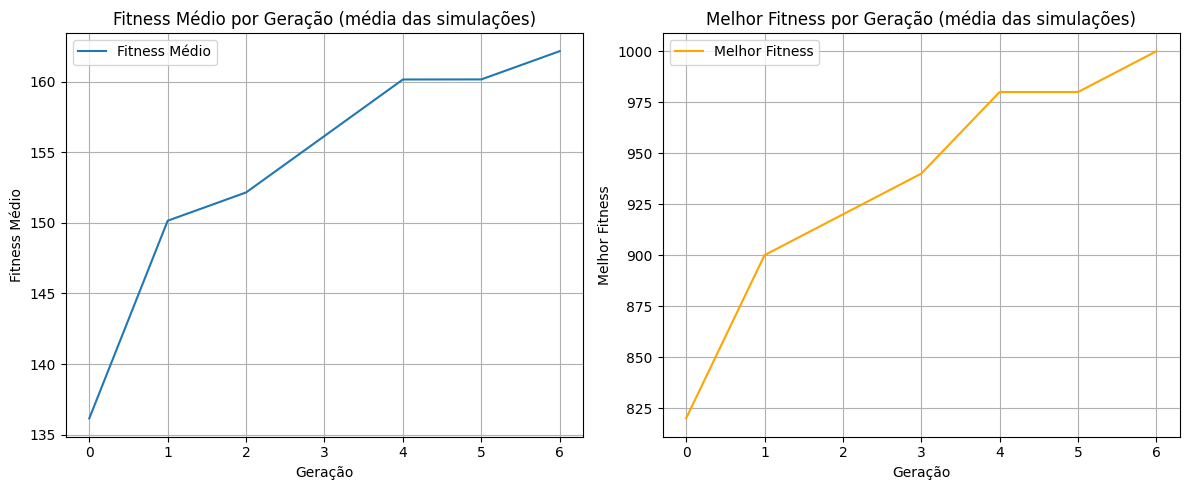

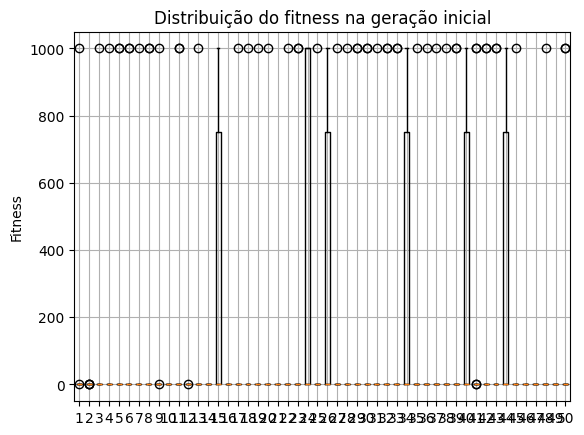

In [161]:
num_sim = 50
avg_curves, best_curves, initial_fitnesses = run_simulations(num_sim)
plot_avg_curves(avg_curves, best_curves)
plot_initial_fitness_box(initial_fitnesses)